## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

In [630]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

# Импорты библиотек и загрузка данных

## Подключение библиотек

In [631]:
# pip install catboost

In [632]:
import numpy as np
import pandas as pd
#import pickle

import matplotlib
#import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
#import sklearn as skl
import catboost as catb

%matplotlib inline

#import random
import warnings
warnings.filterwarnings('ignore')

#from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
#from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#from sklearn.decomposition import PCA
#from sklearn.svm import SVR
#from sklearn.manifold import TSNE
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.metrics import mean_squared_error as mse, r2_score as r2
#from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
#from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
#from sklearn.tree import DecisionTreeRegressor, plot_tree
#from sklearn.preprocessing import StandardScaler
#from IPython.display import Image

from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score)


#from scipy.stats import shapiro
#from scipy.stats import probplot
#from scipy.stats import ttest_ind, mannwhitneyu
#from scipy.stats import chi2_contingency
#from statsmodels.stats.weightstats import zconfint

#matplotlib.rcParams.update({'font.size': 14})  # размер шрифта на графиках

#from catboost import CatBoostClassifier, CatBoostRegressor, Pool

## Пути к директориям и файлам

In [633]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/GB_Course/data/course_project/course_project_train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/GB_Course/data/course_project/course_project_test.csv'

In [634]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [635]:
df_train.shape[1] - 1 == df_test.shape[1]

True

## Используемые функции

In [636]:
# Изменение типа столбцов в указанном df на строковый
def to_Str(df_, list):
    for i in list:
        df_[i] = df_[i].astype(str)

In [637]:
#обработка типов данных
def reduce_mem_usage(df): 
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Работа с данными

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

* **Credit Score** - не было в описании

In [638]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [639]:
df_train.shape

(7500, 17)

In [640]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [641]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

    Поля где есть пропуски:

    Annual Income <br>
    Years in current job <br>
    Months since last delinquent <br> - очень много пропусков
    Bankruptcies <br>
    Credit Score <br>

In [642]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

    2113 отказов при выдаче кредитов

In [643]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


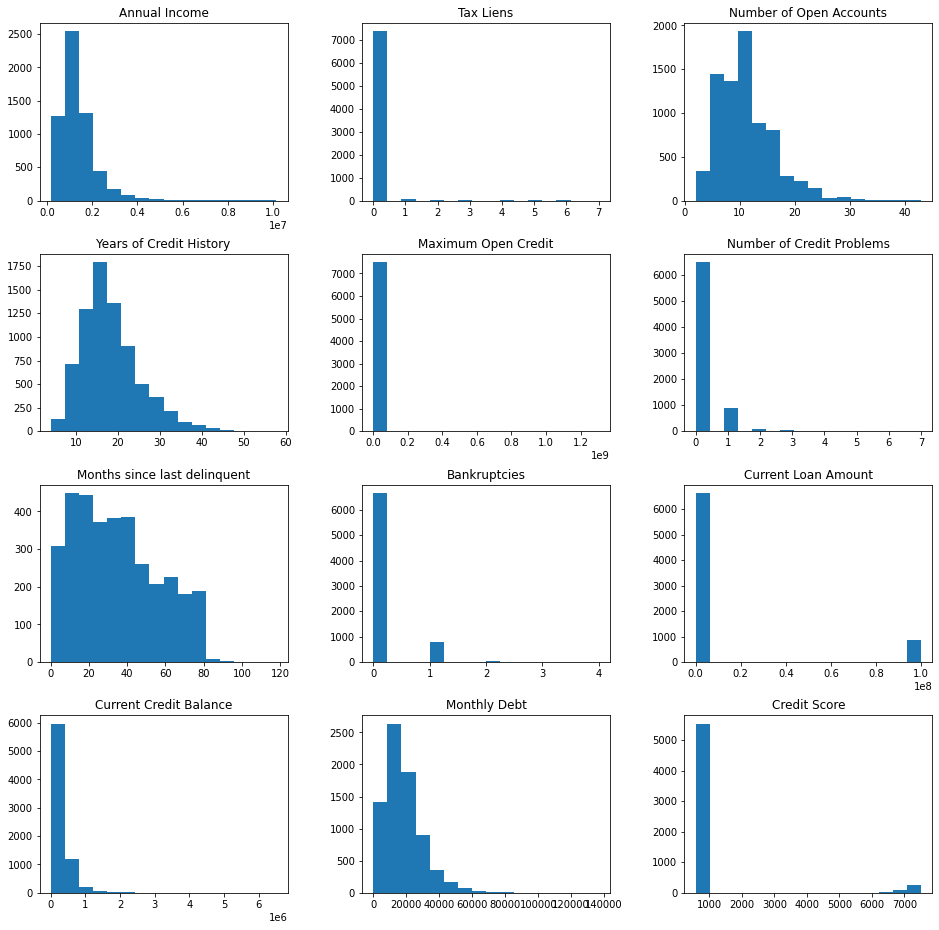

In [644]:
df_num_features = df_train.select_dtypes(include=['float64', 'float32', 'float16'])

df_num_features.hist(figsize=(16, 16), bins=16, grid=False);

    Самые подозрительные параметры это Current Loan Amount, Current Credit Balance и Credit Score
  

# Работа с данными

##### Annual Income - пропуски

    Annual Income NaN - заполнить пропуски медианой, добавить маркер что были пропуски.

In [645]:
df_train['Annual Income'].isna().sum()

1557

In [646]:
df_train['Annual Income NaN'] = 0
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income NaN'] = 1
df_train[df_train['Annual Income NaN']==1].count()
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace = True)

In [647]:
df_train['Annual Income'].isna().sum()

0

##### Years in current job - пропуски

In [648]:
mode = df_train['Years in current job'].mode().values[0]
mode

'10+ years'

In [649]:
df_train['Years in current job NaN'] = 0
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job NaN'] = 1
df_train['Years in current job'].fillna(mode, inplace = True)

##### Months since last delinquent - пропуски

    выше видели, что пропусков очень много, примерно 50%. Заполнить средним или модой не целесообразно, принял решение убрать параметр полностью.

In [650]:
df_train.drop('Months since last delinquent', axis=1, inplace=True)

##### Bankruptcies - пропуски

In [651]:
df_train['Bankruptcies NaN'] = 0
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].median(), inplace = True)
df_train['Bankruptcies'].isna().sum()

0

##### Current Loan Amount - выбросы

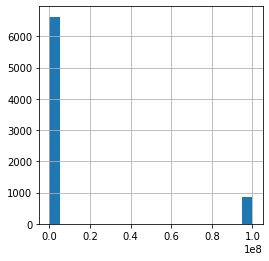

In [652]:
df_train['Current Loan Amount'].hist(bins = 20, figsize = (4, 4))
plt.show()

In [653]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

    870 значений явно не корректны. заменим на медиану

In [654]:
df_train['Current Loan Amount Outlier'] = 0
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount Outlier'] = 1
df_train.loc[df_train['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()

In [655]:
df_train['Current Loan Amount'].value_counts()

309573.0    870
89298.0       6
218064.0      6
216106.0      5
270226.0      5
           ... 
404756.0      1
194414.0      1
420376.0      1
303380.0      1
33792.0       1
Name: Current Loan Amount, Length: 5386, dtype: int64

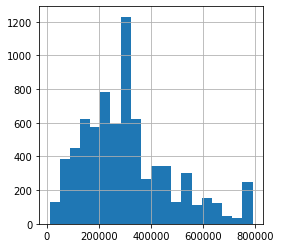

In [656]:
df_train['Current Loan Amount'].hist(bins = 20, figsize = (4, 4))
plt.show()

######Credit Score - пропуски и выбросы

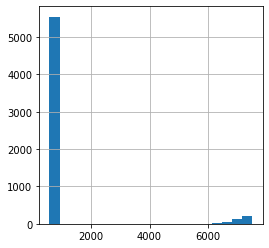

In [657]:
df_train['Credit Score'].hist(bins = 20, figsize = (4, 4))
plt.show()

In [658]:
df_train[df_train['Credit Score'] <= 850]['Credit Score'].count()

5543

In [659]:
df_train[df_train['Credit Score'] > 1000]['Credit Score'].count()

400

    400  значений больших 1000, по факту находятся за значением 6000. Решил разделить на 10

In [660]:
df_train['Credit Score Outlier'] = 0
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score Outlier'] = 1
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] / 10

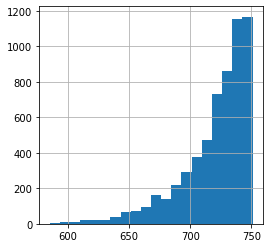

In [661]:
df_train['Credit Score'].hist(bins = 20, figsize = (4, 4))
plt.show()

    заполнение пропусков

In [662]:
df_train['Credit Score'].isna().sum()

1557

In [663]:
df_train['Credit Score NaN'] = 0
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score NaN'] = 1
df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace = True)
df_train['Credit Score'].isna().sum()

0

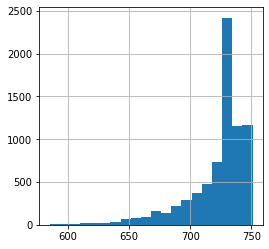

In [664]:
df_train['Credit Score'].hist(bins = 20, figsize = (4, 4))
plt.show()

# Новые признаки

##### Long Term - срок кредита

делаем признак бинарным. если длинный срок крдита, то ставим 1, если короткий то 0.

In [665]:
df_train['Long Term'] = df_train['Term'].map({'Long Term': 1, 'Short Term': 0})

### Years in currnt job

превратим признак в категориальный

In [666]:
df_train['Years in current job'] = df_train['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3})

##### Home Ownership

есть 4 типа домовладения, их сделаем бинарными, каждому свой параметр, 1=да, 0=нет

In [667]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [668]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'])], axis=1)

In [669]:
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income NaN,Years in current job NaN,Bankruptcies NaN,Current Loan Amount Outlier,Credit Score Outlier,Credit Score NaN,Long Term,Have Mortgage,Home Mortgage,Own Home,Rent
0,Own Home,482087.0,3,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,0,1,0,1,0,0,0,0,0,1,0
1,Own Home,1025487.0,3,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,0,0,0,0,0,1,0,0,1,0
2,Home Mortgage,751412.0,2,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,0,0,0,1,0,0,0,0,1,0,0
3,Own Home,805068.0,1,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,0,0,0,0,0,0,0,0,1,0
4,Rent,776264.0,2,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,0,0.0,3.0,8.5,107866.0,0.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0,0,0,0,0,0,0,0,0,0,0,1
7496,Home Mortgage,1533984.0,0,0.0,10.0,26.5,686312.0,0.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,741.0,1,0,0,0,0,1,0,1,0,1,0,0
7497,Rent,1878910.0,1,0.0,12.0,32.1,1778920.0,0.0,0.0,buy a car,Short Term,309573.0,477812.0,12479.0,748.0,0,0,0,0,1,0,0,0,0,0,0,1
7498,Home Mortgage,1168386.0,3,0.0,21.0,26.5,1141250.0,0.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,729.0,0,1,1,0,0,0,1,0,0,1,0,0


##### Credit Score

на основании крдитных очков создадим категории

In [670]:
def credit_score_to_cat(X):
    bins = [300, 579, 669, 739, 799, 850]
    X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
    
    X['Credit Score Cat'].fillna(-1, inplace=True)
    return X

In [671]:
df_train = credit_score_to_cat(df_train)

In [672]:
df_train['Credit Score Cat'].value_counts()

2    5438
3    1660
1     402
Name: Credit Score Cat, dtype: int64

    анализ целей приобритения кредитов

In [673]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

#### df_test

In [674]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [675]:
df_test.shape

(2500, 16)

### Оптимизация типов данных и используемой памяти

In [676]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1.40 MB
Memory usage after optimization is: 0.52 MB
Decreased by 62.7%


In [677]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


# функции на основании выше описанного

In [678]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians=None
        self.modes = None
        self.max_score = 850
        self.max_credit = 99999999.0
                
    def fit(self, X):
        """Сохранение статистик""" 
        X = X.copy()
        # Расчет медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]
                
    def transform(self, X):
        """Трансформация данных"""

        # Credit score
        X['Credit Score Outlier'] = 0
        X['Credit Score NaN'] = 0
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score Outlier'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score NaN'] = 1

        X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] = \
                                X.loc[df_train['Credit Score'] > self.max_score, 'Credit Score'] / 10
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace = True)
        
        # Current Loan Amount
        X['Current Loan Amount Outlier'] = 0
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount Outlier'] = 1
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount'] = self.medians['Current Loan Amount']
                 
        # Annual Income
        X['Annual Income NaN'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income NaN'] = 1
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)
        
        # Years in current job
        X['Years in current job NaN'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job NaN'] = 1
        X['Years in current job'].fillna(self.modes['Years in current job'], inplace = True)
        
        # Months since last delinquent
        X.drop('Months since last delinquent', axis=1, inplace=True)
        
        # Bankruptcies
        X['Bankruptcies NaN'] = 0
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
        X['Bankruptcies'].fillna(self.medians['Bankruptcies'], inplace = True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [679]:
class FeatureGenetator():
    """Генерация новых фич"""
    
      
    def fit(self, X, y=None):
        X = X.copy()
                
    def transform(self, X):
        
        # Term
        X['Long Term'] = X['Term'].map({'Long Term': 1, 'Short Term': 0})
                
        # Years in current job
        X['Years in current job'] = X['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':0, 
                                                                       '3 years':0, 
                                                                       '4 years':1, 
                                                                       '5 years':1, 
                                                                       '6 years':1, 
                                                                       '7 years':2,
                                                                       '8 years':2,
                                                                       '9 years':2,
                                                                       '10+ years':3})
        # Home Ownership
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        
        # Credit Score
        X = self.credit_score_to_cat(X)
        
        return X
    
    def credit_score_to_cat(self, X):
        bins = [300, 579, 669, 739, 799, 850]
        X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)

        X['Credit Score Cat'].fillna(-1, inplace=True)
        return X

# Модельки

In [680]:
feature_names = ['Annual Income', 
                 'Tax Liens', 
                 'Number of Open Accounts', 
                 'Years of Credit History', 
                 'Maximum Open Credit', 
                 'Number of Credit Problems', 
#                  'Months since last delinquent', 
                 'Bankruptcies',
                 'Current Loan Amount', 
                 'Current Credit Balance', 
                 'Monthly Debt', 
                 'Credit Score', 
                 'Years in current job', 
#                  'Purpose'
                ]

new_feature_names = [
#                          'Home Ownership',
#                          'Term',
#                          'Credit Score Outlier',
#                          'Current Loan Amount Outlier',
#                          'Maximum Open Credit Outlier',
#                          'Annual Income NaN',
#                          'Years in current job NaN',
#                          'Bankruptcies NaN',
#                          'Credit Score NaN',
                         'Long Term',
                         'Have Mortgage',
                         'Home Mortgage',
                         'Own Home',
                         'Rent',
                         'Credit Score Cat'
                    ]

target_name = 'Credit Default'

In [681]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [682]:
X = df_train.drop(columns=target_name)
y = df_train[target_name]

In [683]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [684]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)

In [685]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 21), (2475, 21), (2500, 21))

In [686]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)  
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

In [687]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 27), (2475, 27), (2500, 27))

In [688]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

In [689]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 18), (2475, 18), (2500, 18))

In [690]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [691]:
X_train.isna().sum()

Annual Income                0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Years in current job         0
Long Term                    0
Have Mortgage                0
Home Mortgage                0
Own Home                     0
Rent                         0
Credit Score Cat             0
dtype: int64

In [692]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5537482319660536

In [693]:
model_catb = catb.CatBoostClassifier(
                                     silent=True, 
                                     random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=50,
                                     max_depth=5,
                                     min_data_in_leaf=5
                                    )

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [694]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [695]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [696]:
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN
 0.531
TEST
 0.513
TRAIN

              precision    recall  f1-score   support

           0       0.85      0.59      0.70      3611
           1       0.42      0.74      0.53      1414

    accuracy                           0.63      5025
   macro avg       0.63      0.66      0.62      5025
weighted avg       0.73      0.63      0.65      5025

VALID

              precision    recall  f1-score   support

           0       0.84      0.58      0.68      1776
           1       0.40      0.72      0.51       699

    accuracy                           0.62      2475
   macro avg       0.62      0.65      0.60      2475
weighted avg       0.71      0.62      0.63      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1022  754
1                198  501
